## Image alignment with "optical flow" technique

In [3]:
#Load file_names_dataframe from CSV
import pandas as pd
df = pd.read_csv('file_names_dataframe.csv')
display(df.head())

,parking_lot,weather,date,file_path
0,UFPR04,Cloudy,2012-12-29,/Volumes/SSD_1/parking-lot/PKLotYoloData/NoXML...
1,UFPR04,Cloudy,2012-12-29,/Volumes/SSD_1/parking-lot/PKLotYoloData/NoXML...
2,UFPR04,Cloudy,2012-12-29,/Volumes/SSD_1/parking-lot/PKLotYoloData/NoXML...
3,UFPR04,Cloudy,2012-12-29,/Volumes/SSD_1/parking-lot/PKLotYoloData/NoXML...
4,UFPR04,Cloudy,2012-12-29,/Volumes/SSD_1/parking-lot/PKLotYoloData/NoXML...


In [4]:
import cv2
import os
import numpy as np
# Directory to save aligned images
aligned_dir = "aligned_images/ufpr05_optical_flow"
os.makedirs(aligned_dir, exist_ok=True)

# Function to align images using Farneback Optical Flow
def align_with_optical_flow(base_image_path, target_image_path):
    # Read images in grayscale
    base_image = cv2.imread(base_image_path, cv2.IMREAD_GRAYSCALE)
    target_image = cv2.imread(target_image_path, cv2.IMREAD_GRAYSCALE)

    # Compute dense optical flow
    flow = cv2.calcOpticalFlowFarneback(
        base_image, target_image, None, 0.5, 3, 15, 3, 5, 1.2, 0
    )

    # Warp the target image using the flow
    h, w = base_image.shape
    flow_map = np.column_stack((np.repeat(np.arange(h), w), np.tile(np.arange(w), h)))
    flow_map = flow_map.reshape(h, w, 2).astype(np.float32) + flow
    aligned_image = cv2.remap(cv2.imread(target_image_path), flow_map, None, cv2.INTER_LINEAR)

    return aligned_image

# Filter the dataframe for UFPR05 images
ufpr05_images = df[df['parking_lot'] == 'UFPR05']
# Use the first image in UFPR05 as the base image
base_image_path = ufpr05_images.iloc[0]['file_path']

# Align all images in UFPR05
for _, row in ufpr05_images.iterrows():
    target_image_path = row['file_path']
    aligned_image = align_with_optical_flow(base_image_path, target_image_path)

    # Save the aligned image
    aligned_image_path = os.path.join(aligned_dir, os.path.basename(target_image_path))
    cv2.imwrite(aligned_image_path, aligned_image)

print(f"Aligned images saved to {aligned_dir}")

Aligned images saved to aligned_images/ufpr05_optical_flow


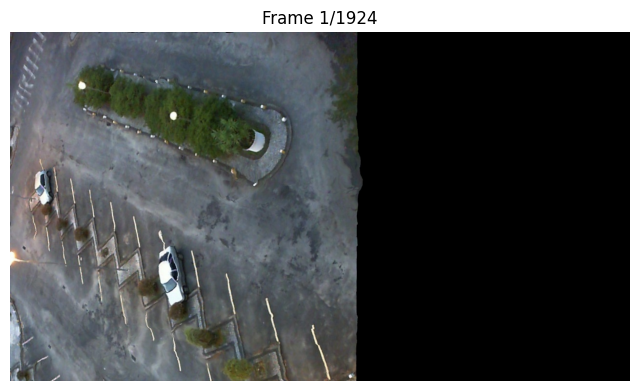

In [7]:
# Save as animation

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
import os

# Path to the aligned images directory
aligned_dir = "aligned_images/ufpr05_optical_flow"

# Get the list of aligned image paths
aligned_image_paths = sorted(
    [os.path.join(aligned_dir, fname) for fname in os.listdir(aligned_dir) if fname.endswith(('.jpg', '.png'))]
)

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(8, 6))

# Initialize the image display with the first aligned image
img_display = ax.imshow(Image.open(aligned_image_paths[0]))
ax.axis('off')  # Turn off axes for better visualization

# Update function for the animation
def update(frame):
    image_path = aligned_image_paths[frame]
    img = Image.open(image_path)
    img_display.set_data(img)
    ax.set_title(f"Frame {frame + 1}/{len(aligned_image_paths)}")
    return img_display,

# Create the animation
ani = FuncAnimation(
    fig, update, frames=len(aligned_image_paths), interval=500, blit=True
)

In [ ]:
# Save the animation as a GIF or MP4 (optional)
ani.save('animations/aligned_animation_optical_flow.mp4', writer='ffmpeg', fps=20)  # Save as MP4